# Spark environment

In [2]:
import pandas as pd
import numpy as np
import math
import os
import datetime
import matplotlib.pyplot as plt
import findspark
import pyspark.sql.functions as f
from pyspark.sql.functions import col, udf
from pyspark.sql.functions import split, col
from pyspark.sql.functions import size
from pyspark.sql.functions import col,lit
from pyspark.sql import DataFrame
import gensim
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models import Phrases
%matplotlib inline

In [3]:
#!find /root -name "pyspark"

find: ‘/root’: Permission non accordée


In [4]:
home = os.environ["HOME"]

D1 = "/.local/lib/python3.9/site-packages/pyspark"
D2 = "/root/anaconda3/lib/python3.9/site-packages/pyspark"

if os.path.exists(D1):
    os.environ["SPARK_HOME"] = home +  D1
elif os.path.exists(D2):
    os.environ["SPARK_HOME"] = home +  D2
else:
    print("PB de path")

os.environ["JAVA_HOME"] ="/usr"

PB de path


### Start spark 

In [5]:
import findspark 
print("findspark.init() initialise les variables d'environnement pour spark") 
findspark.init() 

from pyspark.sql import SparkSession 
from pyspark import SparkConf  

# import pyspark SQL functions
import pyspark.sql.functions as f

# SQL types
from pyspark.sql.types import *



findspark.init() initialise les variables d'environnement pour spark


In [6]:
def demarrer_spark():
    local = "local[*]"
    appName = "TP"
    configLocale = SparkConf().setAppName(appName).setMaster(local).\
    set("spark.executor.memory", "100G").\
    set("spark.driver.memory","50G").\
    set("spark.sql.catalogImplementation","in-memory").\
    set("spark.driver.maxResultSize", "10G")

    spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
    sc = spark.sparkContext
    sc.setLogLevel("ERROR")
    
    print("session démarrée, son id est ", sc.applicationId)
    return spark

spark = demarrer_spark()

session démarrée, son id est  local-1676984091075


###  SQL Magic

In [7]:
from IPython.core.magic import (register_line_magic, register_cell_magic, register_line_cell_magic)

def removeComments(query):
    result = ""
    for line in query.split('\n'):
    if not(line.strip().startswith("--")):
      result += line + "\n"
    return result

@register_line_cell_magic
def sql(line, cell=None):
    "To run a sql query. Use:  %%sql"
    val = cell if cell is not None else line
    tabRequetes = removeComments(val).split(";")
    derniere = None
    est_requete = False
    for r in tabRequetes:
        r = r.strip()
        if len(r) > 2:
          derniere = spark.sql(r)
          est_requete = r.lower().startswith('select') or r.lower().startswith('with')  
    if(est_requete):
      return display(derniere)
    else:
      return print('ok')

display

In [8]:
def display(df, n=10):
    pd.set_option('max_columns', None)
    pd.set_option('max_colwidth', None)
    return df.limit(n).toPandas()

print("display redéfini")

display redéfini


### figure storage folder

In [9]:
#path to the notebook
notebook_dir = "/home/jarrad/Bureau/notebook_sara/figures/"
numero_experience = "experience1/"

# Dataset with embeddings

In [10]:
# Read the file containing the results with embeddings (MRR cos and JACCARD cos) 
# /home/jarrad/Bureau/notebook_sara/experiment/expe_94_vectors.csv :  the path to the file where the results are stored
fichiers_avec_toutes_les_experiences_avec_embeddings = pd.read_csv('/home/jarrad/Bureau/notebook_sara/experiment/expe_94_vectors.csv')
fichiers_avec_toutes_les_experiences_avec_embeddings

,k,dimension,epoch,fonction de similarite,qualite
0,1,2,5,similarite_trajectoires_MRR_cosinus,0.241408
1,2,2,5,similarite_trajectoires_MRR_cosinus,0.243064
2,3,2,5,similarite_trajectoires_MRR_cosinus,0.252588
3,4,2,5,similarite_trajectoires_MRR_cosinus,0.258799
4,5,2,5,similarite_trajectoires_MRR_cosinus,0.264596
...,...,...,...,...,...
4195,20,50,100,similarite_trajectoires_JACCARD_cosinus,0.330435
4196,25,50,100,similarite_trajectoires_JACCARD_cosinus,0.330849
4197,30,50,100,similarite_trajectoires_JACCARD_cosinus,0.330021
4198,40,50,100,similarite_trajectoires_JACCARD_cosinus,0.328364


In [11]:
# Rename dataframe's columns
fichiers_avec_toutes_les_experiences_avec_embeddings_spark = spark.createDataFrame(fichiers_avec_toutes_les_experiences_avec_embeddings).withColumnRenamed("qualite","qualite_avec_embeddings").withColumnRenamed("fonction de similarite","fonction_similarite_avec_embeddings")
display(fichiers_avec_toutes_les_experiences_avec_embeddings_spark, 10)

,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings
0,1,2,5,similarite_trajectoires_MRR_cosinus,0.241408
1,2,2,5,similarite_trajectoires_MRR_cosinus,0.243064
2,3,2,5,similarite_trajectoires_MRR_cosinus,0.252588
3,4,2,5,similarite_trajectoires_MRR_cosinus,0.258799
4,5,2,5,similarite_trajectoires_MRR_cosinus,0.264596
5,6,2,5,similarite_trajectoires_MRR_cosinus,0.276190
6,8,2,5,similarite_trajectoires_MRR_cosinus,0.294824
7,10,2,5,similarite_trajectoires_MRR_cosinus,0.306004
8,12,2,5,similarite_trajectoires_MRR_cosinus,0.311801
9,15,2,5,similarite_trajectoires_MRR_cosinus,0.316356


# Dataset without embeddings

In [12]:
# Read the file containing the results without embeddings (MRR and JACCARD) 
# /home/jarrad/Bureau/notebook_sara/experiment/expe_26_no_vectors.csv :  the path to the file where the results are stored
fichiers_avec_toutes_les_experiences_sans_embeddings = pd.read_csv('/home/jarrad/Bureau/notebook_sara/experiment/expe_26_no_vectors.csv')
fichiers_avec_toutes_les_experiences_sans_embeddings.head(5)

,k,dimension,epoch,fonction de similarite,qualite
0,1,0,0,similarite_trajectoires_JACCARD,0.249275
1,2,0,0,similarite_trajectoires_JACCARD,0.250518
2,3,0,0,similarite_trajectoires_JACCARD,0.256729
3,4,0,0,similarite_trajectoires_JACCARD,0.264182
4,5,0,0,similarite_trajectoires_JACCARD,0.271222


In [13]:
# Rename dataframe's columns
fichiers_avec_toutes_les_experiences_sans_embeddings_spark = spark.createDataFrame(fichiers_avec_toutes_les_experiences_sans_embeddings).withColumnRenamed("fonction de similarite","fonction_similarite_sans_embeddings").withColumnRenamed("qualite","qualite_sans_embeddings")
# display the result
display(fichiers_avec_toutes_les_experiences_sans_embeddings_spark, 5)

,k,dimension,epoch,fonction_similarite_sans_embeddings,qualite_sans_embeddings
0,1,0,0,similarite_trajectoires_JACCARD,0.249275
1,2,0,0,similarite_trajectoires_JACCARD,0.250518
2,3,0,0,similarite_trajectoires_JACCARD,0.256729
3,4,0,0,similarite_trajectoires_JACCARD,0.264182
4,5,0,0,similarite_trajectoires_JACCARD,0.271222


# Join with/without embeddings tables

In [14]:
# Join between tables with /without embeddings
def jointure_table_avec_sans_embeddings(table_avec_embeddings, table_sans_embeddings):
    table_avec_embeddings.createOrReplaceTempView("table_avec_embeddings")
    table_sans_embeddings.createOrReplaceTempView("table_sans_embeddings")
    
    query = """
            select  a.*, s.fonction_similarite_sans_embeddings, s.qualite_sans_embeddings
            from table_avec_embeddings a , table_sans_embeddings s
            where s.k = a.k 
            order by k

            
            """
    return spark.sql(query)

In [15]:
# Call the function and display the result
jointure = jointure_table_avec_sans_embeddings(fichiers_avec_toutes_les_experiences_avec_embeddings_spark, fichiers_avec_toutes_les_experiences_sans_embeddings_spark)
display(jointure,5)

,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings
0,1,2,5,similarite_trajectoires_MRR_cosinus,0.241408,similarite_trajectoires_JACCARD,0.249275
1,1,2,5,similarite_trajectoires_MRR_cosinus,0.241408,similarite_trajectoires_MRR,0.286128
2,1,2,5,similarite_trajectoires_JACCARD_cosinus,0.242236,similarite_trajectoires_JACCARD,0.249275
3,1,2,5,similarite_trajectoires_JACCARD_cosinus,0.242236,similarite_trajectoires_MRR,0.286128
4,1,2,7,similarite_trajectoires_MRR_cosinus,0.249689,similarite_trajectoires_JACCARD,0.249275


## JACCARD/ JACCARD cos Table

In [16]:
# Filtering on the data (keep the results of the JACCARD and JACCARD cos functions)
def table_sim_jaccard(table_experience):
    table_experience.createOrReplaceTempView("table_experience")
    
    
    query = """

            select *
            from table_experience
            where fonction_similarite_sans_embeddings = "similarite_trajectoires_JACCARD"
            and fonction_similarite_avec_embeddings = "similarite_trajectoires_JACCARD_cosinus"
            order by k, dimension, epoch
    
            
            
            """
    return spark.sql(query)

In [17]:
qualite_avec_jaccard = table_sim_jaccard(jointure)
display(qualite_avec_jaccard,5)

,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings
0,1,2,5,similarite_trajectoires_JACCARD_cosinus,0.242236,similarite_trajectoires_JACCARD,0.249275
1,1,2,7,similarite_trajectoires_JACCARD_cosinus,0.244306,similarite_trajectoires_JACCARD,0.249275
2,1,2,10,similarite_trajectoires_JACCARD_cosinus,0.246791,similarite_trajectoires_JACCARD,0.249275
3,1,2,15,similarite_trajectoires_JACCARD_cosinus,0.249689,similarite_trajectoires_JACCARD,0.249275
4,1,2,20,similarite_trajectoires_JACCARD_cosinus,0.245135,similarite_trajectoires_JACCARD,0.249275


##  MRR/ MRR cos Table

In [18]:
# Filtering on the data (keep the results of the MRR and MRR cos functions)
def table_sim_MRR(table_des_experience):
    table_des_experience.createOrReplaceTempView("table_des_experience")
    
    
    query = """

            select *
            from table_des_experience
            where fonction_similarite_sans_embeddings = "similarite_trajectoires_MRR"
            and fonction_similarite_avec_embeddings = "similarite_trajectoires_MRR_cosinus"
            order by k, dimension, epoch
    
            
            
            """
    return spark.sql(query)

In [19]:
qualite_avec_MRR = table_sim_MRR(jointure)
display(qualite_avec_MRR, 5)

,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings
0,1,2,5,similarite_trajectoires_MRR_cosinus,0.241408,similarite_trajectoires_MRR,0.286128
1,1,2,7,similarite_trajectoires_MRR_cosinus,0.249689,similarite_trajectoires_MRR,0.286128
2,1,2,10,similarite_trajectoires_MRR_cosinus,0.248447,similarite_trajectoires_MRR,0.286128
3,1,2,15,similarite_trajectoires_MRR_cosinus,0.248033,similarite_trajectoires_MRR,0.286128
4,1,2,20,similarite_trajectoires_MRR_cosinus,0.244720,similarite_trajectoires_MRR,0.286128


# Benefits of JACCARD-JACCARDS cosinus

In [20]:
# Calculation of the benefit of embeddings 
# Benefit = ((Quality with embeddings / Quality with embeddings) -1) * 100
def table_benefice_JACCARD_JACCARDcos(table_qualites):
    table_qualites.createOrReplaceTempView("table_qualites")
    
    
    query = """

            select k, dimension, epoch, fonction_similarite_avec_embeddings, qualite_avec_embeddings, fonction_similarite_sans_embeddings, qualite_sans_embeddings, ((qualite_avec_embeddings / qualite_sans_embeddings) -1)*100 as benefice_JACCARD_JACCARDcos 
         
            from table_qualites 

    
            
            
            """
    return spark.sql(query)

In [21]:
table_benefice_Jaccard_Jaccardcos = table_benefice_JACCARD_JACCARDcos(qualite_avec_jaccard)
display(table_benefice_Jaccard_Jaccardcos, 5)

,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings,benefice_JACCARD_JACCARDcos
0,1,2,5,similarite_trajectoires_JACCARD_cosinus,0.242236,similarite_trajectoires_JACCARD,0.249275,-2.823920
1,1,2,7,similarite_trajectoires_JACCARD_cosinus,0.244306,similarite_trajectoires_JACCARD,0.249275,-1.993355
2,1,2,10,similarite_trajectoires_JACCARD_cosinus,0.246791,similarite_trajectoires_JACCARD,0.249275,-0.996678
3,1,2,15,similarite_trajectoires_JACCARD_cosinus,0.249689,similarite_trajectoires_JACCARD,0.249275,0.166113
4,1,2,20,similarite_trajectoires_JACCARD_cosinus,0.245135,similarite_trajectoires_JACCARD,0.249275,-1.661130


In [22]:
# Round results to 6 decimal
def round_6_benefice(table_benefices):
    table_benefices.createOrReplaceTempView("table_benefices")
    
    
    
    query = """

            select k, dimension, epoch, fonction_similarite_avec_embeddings, qualite_avec_embeddings, fonction_similarite_sans_embeddings, qualite_sans_embeddings,
            round(benefice_JACCARD_JACCARDcos, 6) 
         
            from table_benefices

    
            
            
            """
    return spark.sql(query)

In [23]:
round_benefice_JACCARD = round_6_benefice(table_benefice_Jaccard_Jaccardcos).withColumnRenamed("round(benefice_JACCARD_JACCARDcos, 6)","benefice_JACCARD_JACCARDcos")
display(round_benefice_JACCARD, 5)

,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings,benefice_JACCARD_JACCARDcos
0,1,2,5,similarite_trajectoires_JACCARD_cosinus,0.242236,similarite_trajectoires_JACCARD,0.249275,-2.823920
1,1,2,7,similarite_trajectoires_JACCARD_cosinus,0.244306,similarite_trajectoires_JACCARD,0.249275,-1.993355
2,1,2,10,similarite_trajectoires_JACCARD_cosinus,0.246791,similarite_trajectoires_JACCARD,0.249275,-0.996678
3,1,2,15,similarite_trajectoires_JACCARD_cosinus,0.249689,similarite_trajectoires_JACCARD,0.249275,0.166113
4,1,2,20,similarite_trajectoires_JACCARD_cosinus,0.245135,similarite_trajectoires_JACCARD,0.249275,-1.661130


## min/max value profit JACCARD vs JACCARD cos

In [24]:
# Calculation of min and max values of JACCARD profit vs. JACCARD cos
def table_Jaccard_Jaccardcos(table_des_benefices):
    table_des_benefices.createOrReplaceTempView("table_des_benefices")
    
    
    query = """

            select min(benefice_JACCARD_JACCARDcos) as benefice_JACCARD_JACCARDcos_min, max(benefice_JACCARD_JACCARDcos) as benefice_JACCARD_JACCARDcos_max,
                    avg(benefice_JACCARD_JACCARDcos) as benefice_JACCARD_JACCARDcos_moyen
         
            from table_des_benefices 

    
            
            
            """
    return spark.sql(query)

In [25]:
min_max_benefice_Jaccard_Jaccardcos = table_Jaccard_Jaccardcos(round_benefice_JACCARD)
display(min_max_benefice_Jaccard_Jaccardcos)

,benefice_JACCARD_JACCARDcos_min,benefice_JACCARD_JACCARDcos_max,benefice_JACCARD_JACCARDcos_moyen
0,-3.986711,11.944444,4.849458


## Optimal combination to achieve JACCARD cos max benefit

In [26]:
def jointure_table_benefice_beneficemax(table_benefice, table_benefice_max):
    table_benefice.createOrReplaceTempView("table_benefice")
    table_benefice_max.createOrReplaceTempView("table_benefice_max")
    
    query = """
            select  b.*
            from table_benefice b , table_benefice_max m
            where b.benefice_JACCARD_JACCARDcos = m.benefice_JACCARD_JACCARDcos_max 

            
            """
    return spark.sql(query)

In [27]:
combinaison_optimale_pour_meilleur_qualite_JACCARD_JACCARdcos = jointure_table_benefice_beneficemax(round_benefice_JACCARD, min_max_benefice_Jaccard_Jaccardcos)
display(combinaison_optimale_pour_meilleur_qualite_JACCARD_JACCARdcos)

,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings,benefice_JACCARD_JACCARDcos
0,15,12,100,similarite_trajectoires_JACCARD_cosinus,0.333747,similarite_trajectoires_JACCARD,0.298137,11.944444


# Benefit of MRR-MRR cosinus

In [28]:
# Calculation of the benefit of embeddings 
# Benefit = ((Quality with embeddings / Quality with embeddings) -1) * 100
def table_benefice_MRR_MRRcos(table_qualites):
    table_qualites.createOrReplaceTempView("table_qualites")
    
    
    query = """

            select k, dimension, epoch, fonction_similarite_avec_embeddings, qualite_avec_embeddings, fonction_similarite_sans_embeddings, qualite_sans_embeddings, ((qualite_avec_embeddings / qualite_sans_embeddings) -1)*100 as benefice_MRR_MRRcos 
         
            from table_qualites 

    
            
            
            """
    return spark.sql(query)

In [29]:
table_benefice_MRR = table_benefice_MRR_MRRcos(qualite_avec_MRR)
display(table_benefice_MRR, 5)

,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings,benefice_MRR_MRRcos
0,1,2,5,similarite_trajectoires_MRR_cosinus,0.241408,similarite_trajectoires_MRR,0.286128,-15.629522
1,1,2,7,similarite_trajectoires_MRR_cosinus,0.249689,similarite_trajectoires_MRR,0.286128,-12.735166
2,1,2,10,similarite_trajectoires_MRR_cosinus,0.248447,similarite_trajectoires_MRR,0.286128,-13.169320
3,1,2,15,similarite_trajectoires_MRR_cosinus,0.248033,similarite_trajectoires_MRR,0.286128,-13.314038
4,1,2,20,similarite_trajectoires_MRR_cosinus,0.244720,similarite_trajectoires_MRR,0.286128,-14.471780


In [30]:
def round_6_benefice(table_benefices):
    table_benefices.createOrReplaceTempView("table_benefices")
    
    
    query = """

            select k, dimension, epoch, fonction_similarite_avec_embeddings, qualite_avec_embeddings, fonction_similarite_sans_embeddings, qualite_sans_embeddings,
            round(benefice_MRR_MRRcos, 6) 
         
            from table_benefices

    
            
            
            """
    return spark.sql(query)

In [31]:
round_benefice_MRR = round_6_benefice(table_benefice_MRR).withColumnRenamed("round(benefice_MRR_MRRcos, 6)","benefice_MRR_MRRcos")
display(round_benefice_MRR, 5)

,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings,benefice_MRR_MRRcos
0,1,2,5,similarite_trajectoires_MRR_cosinus,0.241408,similarite_trajectoires_MRR,0.286128,-15.629522
1,1,2,7,similarite_trajectoires_MRR_cosinus,0.249689,similarite_trajectoires_MRR,0.286128,-12.735166
2,1,2,10,similarite_trajectoires_MRR_cosinus,0.248447,similarite_trajectoires_MRR,0.286128,-13.169320
3,1,2,15,similarite_trajectoires_MRR_cosinus,0.248033,similarite_trajectoires_MRR,0.286128,-13.314038
4,1,2,20,similarite_trajectoires_MRR_cosinus,0.244720,similarite_trajectoires_MRR,0.286128,-14.471780


## min/max value profit MRR vs MRR cos

In [32]:
def table_Benefice_min_max_avg_MRR_MRRcos(table_benefice):
    table_benefice.createOrReplaceTempView("table_benefice")
    
    
    query = """

            select min(benefice_MRR_MRRcos) as benefice_MRR_MRRcos_min, max(benefice_MRR_MRRcos) as benefice_MRR_MRRcos_max,
                    avg(benefice_MRR_MRRcos) as benefice_MRR_MRRcos_moyen
         
            from table_benefice

    
            
            
            """
    return spark.sql(query)

In [33]:
min_max_benefice_MRR_MRRcos= table_Benefice_min_max_avg_MRR_MRRcos(round_benefice_MRR)
display(min_max_benefice_MRR_MRRcos)

,benefice_MRR_MRRcos_min,benefice_MRR_MRRcos_max,benefice_MRR_MRRcos_moyen
0,-19.863014,7.104558,-2.903626


## Optimal combination to achieve MRR cos max benefit

In [34]:
def jointure_table_benefice_beneficemax(table_benefice_MRR, table_benefice_max_MRR):
    table_benefice_MRR.createOrReplaceTempView("table_benefice_MRR")
    table_benefice_max_MRR.createOrReplaceTempView("table_benefice_max_MRR")
    
    query = """
            select  b.*
            from table_benefice_MRR b , table_benefice_max_MRR m
            where b.benefice_MRR_MRRcos = m.benefice_MRR_MRRcos_max 

            
            """
    return spark.sql(query)

In [35]:
combinaison_optimale_pour_meilleur_qualite_MRR_MRRcos = jointure_table_benefice_beneficemax(round_benefice_MRR, min_max_benefice_MRR_MRRcos)
display(combinaison_optimale_pour_meilleur_qualite_MRR_MRRcos)

,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings,benefice_MRR_MRRcos
0,20,30,100,similarite_trajectoires_MRR_cosinus,0.330849,similarite_trajectoires_MRR,0.308903,7.104558
1,25,6,7,similarite_trajectoires_MRR_cosinus,0.330849,similarite_trajectoires_MRR,0.308903,7.104558
2,25,30,7,similarite_trajectoires_MRR_cosinus,0.330849,similarite_trajectoires_MRR,0.308903,7.104558


# curves

## Benefit with fixed k, epoch, and variable dimension

### MRR-MRRcos (k = 20 et epoch=100)

In [104]:
benefice_MRR_k_50 = round_benefice_MRR.where("k=20 and epoch=100")
display(benefice_MRR_k_50,5)

,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings,benefice_MRR_MRRcos
0,20,2,100,similarite_trajectoires_MRR_cosinus,0.317184,similarite_trajectoires_MRR,0.308903,2.680965
1,20,3,100,similarite_trajectoires_MRR_cosinus,0.320083,similarite_trajectoires_MRR,0.308903,3.619303
2,20,4,100,similarite_trajectoires_MRR_cosinus,0.323810,similarite_trajectoires_MRR,0.308903,4.825737
3,20,5,100,similarite_trajectoires_MRR_cosinus,0.324224,similarite_trajectoires_MRR,0.308903,4.959786
4,20,6,100,similarite_trajectoires_MRR_cosinus,0.320497,similarite_trajectoires_MRR,0.308903,3.753351


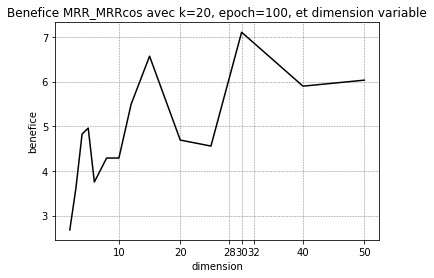

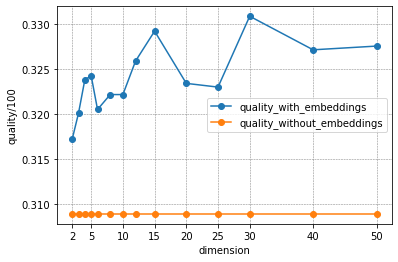

In [105]:
benefice_MRR_k_50_pandas = benefice_MRR_k_50.toPandas()
x = benefice_MRR_k_50_pandas["dimension"]
y = benefice_MRR_k_50_pandas["benefice_MRR_MRRcos"]
plt.plot(x, y, 'k')
axes = plt.gca()
grid_points = [10, 20, 28,30,32, 40, 50]
axes.xaxis.set_ticks(grid_points)
plt.grid(True, color = 'grey', linestyle = '--', linewidth = 0.5)
plt.title('Benefice MRR_MRRcos avec k=20, epoch=100, et dimension variable')
plt.xlabel('dimension')
plt.ylabel('benefice')
plt.subplots_adjust(left=0.15)
plt.savefig(notebook_dir + numero_experience + "benefice_MRRcos_k20_epoch100_dimension_variable.png")
plt.show()


x = benefice_MRR_k_50_pandas["dimension"]
y1 = benefice_MRR_k_50_pandas["qualite_avec_embeddings"]
y2 = benefice_MRR_k_50_pandas["qualite_sans_embeddings"]
plt.plot(x, y1, '-o', label="quality_with_embeddings")
plt.plot(x, y2, '-o', label="quality_without_embeddings")
axes = plt.gca()
grid_points = [2,5,10, 15,20,25,30, 40,50]
axes.xaxis.set_ticks(grid_points)
plt.grid(True, color = 'grey', linestyle = '--', linewidth = 0.5)
#plt.title('qualités avec et sans embeddings avec k=20, epoch=100, et dimension variable')
axes = plt.gca()
axes.set_xlabel('dimension')
axes.set_ylabel('quality/100')
plt.legend()
plt.savefig(notebook_dir + numero_experience + "qualite_MRRcos_k20_epoch100_dimension_variable.png")
plt.show()

### JACCARD-JACCARDcos (k=15 et epoch=100)

In [86]:
benefice_JACCARD_k_15 = round_benefice_JACCARD.where("k=15 and epoch =100")
display(benefice_JACCARD_k_15,5)

,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings,benefice_JACCARD_JACCARDcos
0,15,2,100,similarite_trajectoires_JACCARD_cosinus,0.314286,similarite_trajectoires_JACCARD,0.298137,5.416667
1,15,3,100,similarite_trajectoires_JACCARD_cosinus,0.315942,similarite_trajectoires_JACCARD,0.298137,5.972222
2,15,4,100,similarite_trajectoires_JACCARD_cosinus,0.322153,similarite_trajectoires_JACCARD,0.298137,8.055556
3,15,5,100,similarite_trajectoires_JACCARD_cosinus,0.327536,similarite_trajectoires_JACCARD,0.298137,9.861111
4,15,6,100,similarite_trajectoires_JACCARD_cosinus,0.321739,similarite_trajectoires_JACCARD,0.298137,7.916667


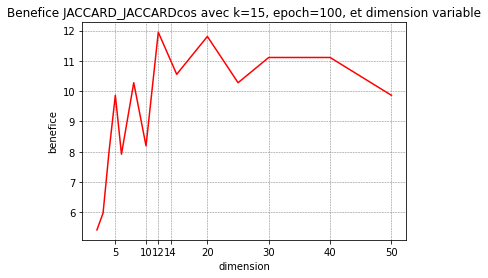

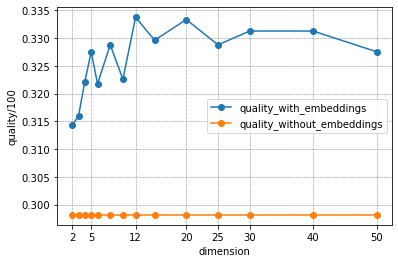

In [106]:
benefice_JACCARD_k_15_pandas = benefice_JACCARD_k_15.toPandas()
x = benefice_JACCARD_k_15_pandas["dimension"]
y = benefice_JACCARD_k_15_pandas["benefice_JACCARD_JACCARDcos"]
plt.plot(x, y, 'r')
axes = plt.gca()
grid_points = [5, 10., 12., 14., 20, 30, 40, 50]
axes.xaxis.set_ticks(grid_points)
plt.grid(True, color = 'grey', linestyle = '--', linewidth = 0.5)
plt.title('Benefice JACCARD_JACCARDcos avec k=15, epoch=100, et dimension variable')
plt.xlabel('dimension')
plt.ylabel('benefice')
plt.subplots_adjust(left=0.15)
plt.savefig(notebook_dir + numero_experience + "benefice_JACCARDcos_k15_epoch100_dimension_variable.png")
plt.show()


x = benefice_JACCARD_k_15_pandas["dimension"]
y1 = benefice_JACCARD_k_15_pandas["qualite_avec_embeddings"]
y2 = benefice_JACCARD_k_15_pandas["qualite_sans_embeddings"]
plt.plot(x, y1, '-o', label="quality_with_embeddings")
plt.plot(x, y2, '-o', label="quality_without_embeddings")
axes = plt.gca()
grid_points = [2,5,12,20,25,30, 40,50]
axes.xaxis.set_ticks(grid_points)
plt.grid(True, color = 'grey', linestyle = '--', linewidth = 0.5)
#plt.title('qualités avec et sans embeddings avec k=15, epoch=100, et dimension variable')
axes.set_xlabel('dimension')
axes.set_ylabel('quality/100')
plt.legend()
plt.savefig(notebook_dir + numero_experience + "qualite_JACCARDcos_k15_epoch100_dimension_variable.png")
plt.show()


## Profit with dimension, fixed epochs, and variable k

### MRR-MRRcos (dimension = 25 et epoch=100)

In [92]:
benefice_MRR_dimension_15 = round_benefice_MRR.where("dimension=25 and epoch=100")
display(benefice_MRR_dimension_15,5)

,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings,benefice_MRR_MRRcos
0,1,25,100,similarite_trajectoires_MRR_cosinus,0.254244,similarite_trajectoires_MRR,0.286128,-11.143271
1,2,25,100,similarite_trajectoires_MRR_cosinus,0.256315,similarite_trajectoires_MRR,0.302277,-15.205479
2,3,25,100,similarite_trajectoires_MRR_cosinus,0.268323,similarite_trajectoires_MRR,0.305176,-12.075984
3,4,25,100,similarite_trajectoires_MRR_cosinus,0.276190,similarite_trajectoires_MRR,0.306418,-9.864865
4,5,25,100,similarite_trajectoires_MRR_cosinus,0.282402,similarite_trajectoires_MRR,0.308075,-8.333333


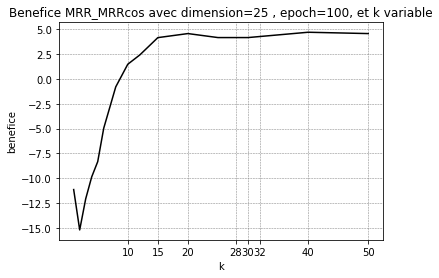

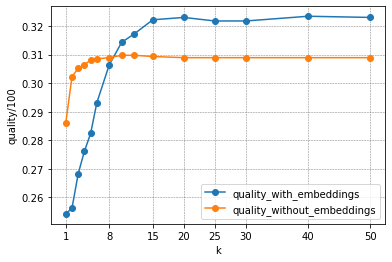

In [94]:
benefice_MRR_dimension_15_pandas = benefice_MRR_dimension_15.toPandas()
x = benefice_MRR_dimension_15_pandas["k"]
y = benefice_MRR_dimension_15_pandas["benefice_MRR_MRRcos"]
plt.plot(x, y, 'k')
axes = plt.gca()
grid_points = [10, 15, 20, 28,30,32, 40, 50]
axes.xaxis.set_ticks(grid_points)
plt.grid(True, color = 'grey', linestyle = '--', linewidth = 0.5)
plt.title('Benefice MRR_MRRcos avec k=20, epoch=100, et dimension variable')

plt.title('Benefice MRR_MRRcos avec dimension=25 , epoch=100, et k variable')
plt.xlabel('k')
plt.ylabel('benefice')
plt.subplots_adjust(left=0.15)
plt.savefig(notebook_dir + numero_experience + "benefice_MRR_dimension25_epoch100_k_variable.png")
plt.show()


x = benefice_MRR_dimension_15_pandas["k"]
y1 = benefice_MRR_dimension_15_pandas["qualite_avec_embeddings"]
y2 = benefice_MRR_dimension_15_pandas["qualite_sans_embeddings"]
plt.plot(x, y1, '-o', label="quality_with_embeddings")
plt.plot(x, y2, '-o', label="quality_without_embeddings")
axes = plt.gca()
grid_points = [1,8, 15,20,25,30, 40,50]
axes.xaxis.set_ticks(grid_points)
plt.grid(True, color = 'grey', linestyle = '--', linewidth = 0.5)
#plt.title('qualités avec et sans embeddings avec dimension=25, epoch=100, et k variable')
axes.set_xlabel('k')
axes.set_ylabel('quality/100')
plt.legend()
plt.savefig(notebook_dir + numero_experience + "qualite_MRR_dimension25_epoch100_k_variable.png")
plt.show()

### JACCARD-JACCARDcos (dimension =25 et epoch=100)

In [96]:
benefice_JACCARD_dimension_4 = round_benefice_JACCARD.where("dimension=25 and epoch=100")
display(benefice_JACCARD_dimension_4,5)

,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings,benefice_JACCARD_JACCARDcos
0,1,25,100,similarite_trajectoires_JACCARD_cosinus,0.256729,similarite_trajectoires_JACCARD,0.249275,2.990033
1,2,25,100,similarite_trajectoires_JACCARD_cosinus,0.258385,similarite_trajectoires_JACCARD,0.250518,3.140496
2,3,25,100,similarite_trajectoires_JACCARD_cosinus,0.271222,similarite_trajectoires_JACCARD,0.256729,5.645161
3,4,25,100,similarite_trajectoires_JACCARD_cosinus,0.281988,similarite_trajectoires_JACCARD,0.264182,6.739812
4,5,25,100,similarite_trajectoires_JACCARD_cosinus,0.290683,similarite_trajectoires_JACCARD,0.271222,7.175573


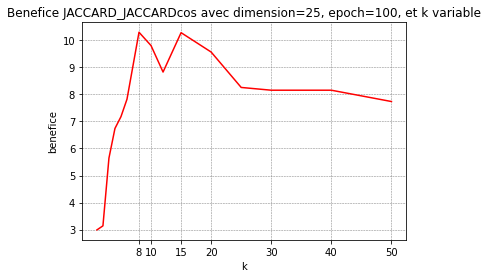

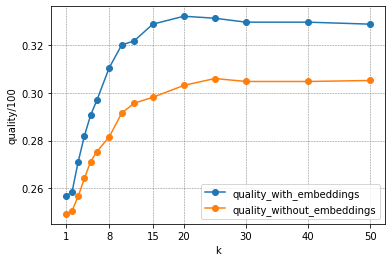

In [97]:
benefice_JACCARD_dimension_4_pandas = benefice_JACCARD_dimension_4.toPandas()
x = benefice_JACCARD_dimension_4_pandas["k"]
y = benefice_JACCARD_dimension_4_pandas["benefice_JACCARD_JACCARDcos"]
plt.plot(x, y, 'r')
axes = plt.gca()
grid_points = [8, 10, 15,20,30, 40, 50]
axes.xaxis.set_ticks(grid_points)
plt.grid(True, color = 'grey', linestyle = '--', linewidth = 0.5)
plt.title('Benefice JACCARD_JACCARDcos avec dimension=25, epoch=100, et k variable')
plt.xlabel('k')
plt.ylabel('benefice')
plt.subplots_adjust(left=0.15)
plt.savefig(notebook_dir + numero_experience + "benefice_JACCARD_dimension25_epoch100_k_variable.png")
plt.show()


x = benefice_JACCARD_dimension_4_pandas["k"]
y1 = benefice_JACCARD_dimension_4_pandas["qualite_avec_embeddings"]
y2 = benefice_JACCARD_dimension_4_pandas["qualite_sans_embeddings"]
plt.plot(x, y1, '-o', label="quality_with_embeddings")
plt.plot(x, y2, '-o', label="quality_without_embeddings")
axes = plt.gca()
grid_points = [1,8, 15,20,30, 40,50]
axes.xaxis.set_ticks(grid_points)
plt.grid(True, color = 'grey', linestyle = '--', linewidth = 0.5)
#plt.title('qualités avec et sans embeddings avec dimension=25, epoch=100, et k variable')
axes = plt.gca()
axes.set_xlabel('k')
axes.set_ylabel('quality/100')
plt.legend()
plt.savefig(notebook_dir + numero_experience + "qualite_JACCARD_dimension25_epoch100_k_variable.png")
plt.show()

## Profit with fixed size, k, and variable epochs

### MRR-MRRcos (dimension = 25 et k=20)

In [99]:
benefice_MRR_dimension_15 = round_benefice_MRR.where("dimension=25 and k=20")
display(benefice_MRR_dimension_15,5)

,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings,benefice_MRR_MRRcos
0,20,25,5,similarite_trajectoires_MRR_cosinus,0.322981,similarite_trajectoires_MRR,0.308903,4.557641
1,20,25,7,similarite_trajectoires_MRR_cosinus,0.326294,similarite_trajectoires_MRR,0.308903,5.630027
2,20,25,10,similarite_trajectoires_MRR_cosinus,0.325466,similarite_trajectoires_MRR,0.308903,5.361930
3,20,25,15,similarite_trajectoires_MRR_cosinus,0.318427,similarite_trajectoires_MRR,0.308903,3.083110
4,20,25,20,similarite_trajectoires_MRR_cosinus,0.324224,similarite_trajectoires_MRR,0.308903,4.959786


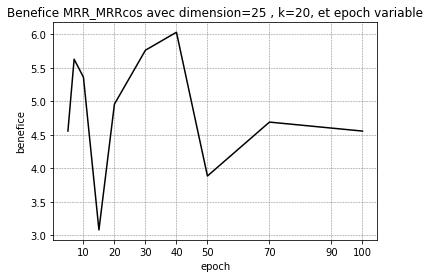

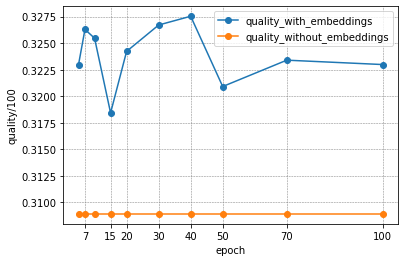

In [100]:
benefice_MRR_dimension_15_pandas = benefice_MRR_dimension_15.toPandas()
x = benefice_MRR_dimension_15_pandas["epoch"]
y = benefice_MRR_dimension_15_pandas["benefice_MRR_MRRcos"]
plt.plot(x, y, 'k')
axes = plt.gca()
grid_points = [10,20,30, 40,  50, 70, 90, 100]
axes.xaxis.set_ticks(grid_points)
plt.grid(True, color = 'grey', linestyle = '--', linewidth = 0.5)
plt.title('Benefice MRR_MRRcos avec dimension=25 , k=20, et epoch variable')
plt.xlabel('epoch')
plt.ylabel('benefice')
plt.subplots_adjust(left=0.15)
plt.savefig(notebook_dir + numero_experience + "benefice_MRR_dimension25_k20_epoch_variable.png")
plt.show()


x = benefice_MRR_dimension_15_pandas["epoch"]
y1 = benefice_MRR_dimension_15_pandas["qualite_avec_embeddings"]
y2 = benefice_MRR_dimension_15_pandas["qualite_sans_embeddings"]
plt.plot(x, y1, '-o', label="quality_with_embeddings")
plt.plot(x, y2, '-o', label="quality_without_embeddings")
axes = plt.gca()
grid_points = [7, 15,20,30, 40,50, 70, 100]
axes.xaxis.set_ticks(grid_points)
plt.grid(True, color = 'grey', linestyle = '--', linewidth = 0.5)
#plt.title('qualités avec et sans embeddings avec dimension=25 , k=20, et epoch variable')
axes = plt.gca()
axes.set_xlabel('epoch')
axes.set_ylabel('quality/100')
plt.legend()
plt.savefig(notebook_dir + numero_experience + "qualite_MRR_dimension25_k20_epoch_variable.png")
plt.show()

### JACCARD-JACCARDcos (dimension = 25 et k=15)

In [102]:
benefice_JACCARD_dimension_4 = round_benefice_JACCARD.where("dimension=25 and k=15")
display(benefice_JACCARD_dimension_4,5)

,k,dimension,epoch,fonction_similarite_avec_embeddings,qualite_avec_embeddings,fonction_similarite_sans_embeddings,qualite_sans_embeddings,benefice_JACCARD_JACCARDcos
0,15,25,5,similarite_trajectoires_JACCARD_cosinus,0.314286,similarite_trajectoires_JACCARD,0.298137,5.416667
1,15,25,7,similarite_trajectoires_JACCARD_cosinus,0.313872,similarite_trajectoires_JACCARD,0.298137,5.277778
2,15,25,10,similarite_trajectoires_JACCARD_cosinus,0.316356,similarite_trajectoires_JACCARD,0.298137,6.111111
3,15,25,15,similarite_trajectoires_JACCARD_cosinus,0.319669,similarite_trajectoires_JACCARD,0.298137,7.222222
4,15,25,20,similarite_trajectoires_JACCARD_cosinus,0.318427,similarite_trajectoires_JACCARD,0.298137,6.805556


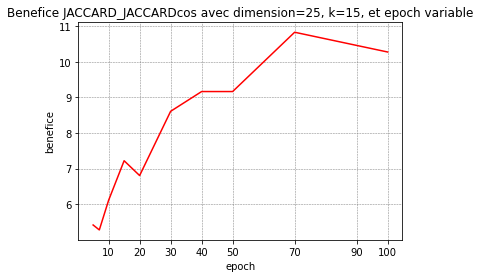

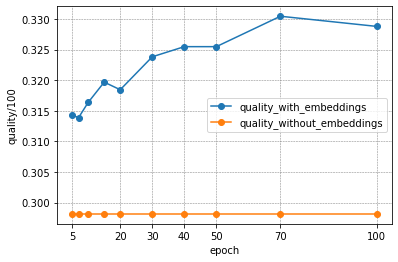

In [103]:
benefice_JACCARD_dimension_4_pandas = benefice_JACCARD_dimension_4.toPandas()
x = benefice_JACCARD_dimension_4_pandas["epoch"]
y = benefice_JACCARD_dimension_4_pandas["benefice_JACCARD_JACCARDcos"]
plt.plot(x, y, 'r')
axes = plt.gca()
grid_points = [10,20,30, 40,  50, 70, 90, 100]
axes.xaxis.set_ticks(grid_points)
plt.grid(True, color = 'grey', linestyle = '--', linewidth = 0.5)
plt.title('Benefice JACCARD_JACCARDcos avec dimension=25, k=15, et epoch variable')
plt.xlabel('epoch')
plt.ylabel('benefice')
plt.subplots_adjust(left=0.15)
plt.savefig(notebook_dir + numero_experience + "benefice_JACCARD_dimension25_k15_epoch_variable.png")
plt.show()


x = benefice_JACCARD_dimension_4_pandas["epoch"]
y1 = benefice_JACCARD_dimension_4_pandas["qualite_avec_embeddings"]
y2 = benefice_JACCARD_dimension_4_pandas["qualite_sans_embeddings"]
plt.plot(x, y1, '-o', label="quality_with_embeddings")
plt.plot(x, y2, '-o', label="quality_without_embeddings")
axes = plt.gca()
grid_points = [5,20,30, 40,50, 70, 100]
axes.xaxis.set_ticks(grid_points)
plt.grid(True, color = 'grey', linestyle = '--', linewidth = 0.5)
#plt.title('qualités avec et sans embeddings avec dimension=25, k=15, et epoch variable')
axes = plt.gca()
axes.set_xlabel('epoch')
axes.set_ylabel('quality/100')
plt.legend()
plt.savefig(notebook_dir + numero_experience + "qualite_JACCARD_dimension25_k15_epoch_variable.png")
plt.show()